In [1]:
import numpy as np
import glob
import os
from tqdm import tqdm
import re
import pandas as pd  # Added import for pd.DataFrame
import my_utils as myu  # Ensure 'myu' is defined with necessary functions

def find_global_bounds(subfolders):
    """Calculate global bounds based on the 30th VTK file in the later files across all subfolders."""
    global_min_x, global_min_y = float('inf'), float('inf')  # Initialize min values to infinity
    global_max_x, global_max_y = float('-inf'), float('-inf')  # Initialize max values to negative infinity

    # Loop through each subfolder to find the global bounds
    for subfolder in tqdm(subfolders, desc="Calculating global bounds"):
        vtk_files = glob.glob(os.path.join(subfolder, 'outputs/*.vtk'))  # Get all VTK files in the folder
        file_details = []
        for file in vtk_files:
            try:
                num = int(file.split('_')[-1].split('.')[0])  # Extract frame number from file name
                file_details.append((file, num))
            except ValueError:
                print(f"Warning: Unable to parse file number from '{file}'. Skipping this file.")

        file_details_sorted = sorted(file_details, key=lambda x: x[1])  # Sort files based on frame number

        # Focus only on files with frame number greater than or equal to 150001
        later_files = [file for file, num in file_details_sorted if num >= 150001]
        if later_files:
            # Ensure we have at least 20 files; if fewer, use all available files
            if len(later_files) >= 20:
                selected_indices = np.linspace(0, len(later_files) - 1, 20, dtype=int)  # Select 20 evenly spaced files
                later_selected = [later_files[i] for i in selected_indices]
            else:
                print(f"Warning: Not enough later files in '{subfolder}'. Required: 20, Found: {len(later_files)}.")
                later_selected = later_files

            # Use the last selected file to update the global bounds
            for last_file in later_selected[-1:]:
                data = myu.read_mesh_cellCon_exception(last_file, 1, 0)  # Read the mesh and field data
                if data:
                    points = data[0]  # Extract points data
                    min_x, min_y = np.min(points, axis=0)  # Get min x and y values
                    max_x, max_y = np.max(points, axis=0)  # Get max x and y values
                    # Update the global bounds based on the current file
                    global_min_x = min(global_min_x, min_x)
                    global_min_y = min(global_min_y, min_y)
                    global_max_x = max(global_max_x, max_x)
                    global_max_y = max(global_max_y, max_y)

    # Return the global min and max coordinates
    return global_min_x, global_min_y, global_max_x, global_max_y

def interpolate_data_for_folder(folder_path, global_bounds, grid_size=1.0):
    """Interpolate selected VTK files within a folder using specified global bounds, with progress output."""
    # Unpack the global bounds
    global_min_x, global_min_y, global_max_x, global_max_y = global_bounds
    # Generate grid points based on the global bounds and grid size
    x_coords = np.arange(global_min_x, global_max_x + grid_size, grid_size)
    y_coords = np.arange(global_min_y, global_max_y + grid_size, grid_size)
    grid_x, grid_y = np.meshgrid(x_coords, y_coords)  # Create a mesh grid for interpolation
    grid_points = np.vstack([grid_x.ravel(), grid_y.ravel()]).T  # Flatten the grid points into a 2D array

    interpolated_data = []  # List to store interpolated data for each file
    all_vtk_files = glob.glob(os.path.join(folder_path, 'outputs/*.vtk'))  # Get all VTK files in the folder
    file_details = []
    for file in all_vtk_files:
        try:
            num = int(file.split('_')[-1].split('.')[0])  # Extract frame number from file name
            file_details.append((file, num))
        except ValueError:
            print(f"Warning: Unable to parse file number from '{file}'. Skipping this file.")

    file_details_sorted = sorted(file_details, key=lambda x: x[1])  # Sort files based on frame number

    # Separate early files (<= 150000) and later files (>= 150001)
    early_files = [file for file, num in file_details_sorted if num <= 150000]
    later_files = [file for file, num in file_details_sorted if num >= 150001]

    # Select a limited number of early files (maximum 10)
    if len(early_files) >= 10:
        selected_indices_early = np.linspace(0, len(early_files) - 1, 10, dtype=int)  # Select 10 evenly spaced files
        early_selected = [early_files[i] for i in selected_indices_early]
    else:
        print(f"Warning: Not enough early files in '{folder_path}'. Required: 10, Found: {len(early_files)}.")
        early_selected = early_files

    # Select a limited number of later files (maximum 20)
    if len(later_files) >= 20:
        selected_indices_later = np.linspace(0, len(later_files) - 1, 20, dtype=int)  # Select 20 evenly spaced files
        later_selected = [later_files[i] for i in selected_indices_later]
    elif len(later_files) > 0:
        print(f"Warning: Not enough later files in '{folder_path}'. Required: 20, Found: {len(later_files)}.")
        later_selected = later_files  # Select all available later files
    else:
        print(f"Error: No files found with numbers >= 150001 in '{folder_path}'. Skipping this folder.")
        return None, None, None  # Skip the folder if no valid files are found

    selected_files = early_selected + later_selected  # Combine early and later selected files

    if not selected_files:
        print(f"Error: No valid files selected in '{folder_path}'. Skipping this folder.")
        return None, None, None

    folder_name = os.path.basename(folder_path)  # Get the folder name for display
    desc = f'Interpolating in {folder_name}'  # Description for progress bar

    last_valid_step_data = None  # Initialize a variable to store the last valid data

    # Process each selected file
    with tqdm(total=len(selected_files), desc=desc, unit='file') as progress:
        for filename in selected_files:
            data = myu.read_mesh_cellCon_exception(filename, 1, 0)  # Read the mesh and field data
            if data:
                points, fields, _, _ = data  # Extract points and scalar fields
                interpolated_step_data = {}
                for field_name, values in fields.items():
                    try:
                        # Interpolate each field using the grid points
                        interpolated_values = myu.interpolate_features_cKD(points, {field_name: values}, grid_points, k=3)
                        interpolated_matrix = interpolated_values[field_name].reshape(len(y_coords), len(x_coords))
                        interpolated_step_data[field_name] = interpolated_matrix  # Store the interpolated matrix
                    except Exception as e:
                        print(f"Warning: Interpolation failed for field '{field_name}' in file '{filename}': {e}")
                        interpolated_step_data[field_name] = np.full((len(y_coords), len(x_coords)), np.nan)  # Assign NaNs on failure
                interpolated_data.append(interpolated_step_data)  # Append interpolated data for this file
                last_valid_step_data = interpolated_step_data  # Update last valid data
            else:
                if last_valid_step_data is not None:
                    print(f"Info: Using previous valid data for file '{filename}'.")
                    interpolated_data.append(last_valid_step_data.copy())  # Use the last valid data
                else:
                    print(f"Warning: No previous valid data to duplicate for file '{filename}'. Assigning NaNs.")
                    # Assign NaNs for all fields if no previous data exists
                    duplicated_step_data = {field: np.full((len(y_coords), len(x_coords)), np.nan) for field in myu.REQUIRED_FIELDS}
                    interpolated_data.append(duplicated_step_data)
            progress.update(1)  # Update progress bar

    return interpolated_data, grid_x, grid_y  # Return the interpolated data and grid

def process_all_cases(base_path):
    """Process all cases (subfolders) in the specified base path."""
    subfolders = glob.glob(os.path.join(base_path, 'io2D_ND*'))  # Get all subfolders matching the pattern

    # Sort subfolders based on the numeric part of the folder name (e.g., ND001, ND002, etc.)
    subfolders.sort(key=lambda x: int(re.search(r'ND(\d+)', os.path.basename(x)).group(1)))

    if not subfolders:
        print(f"Error: No subfolders found in '{base_path}'.")
        return {}

    global_bounds = find_global_bounds(subfolders)  # Calculate global bounds based on selected VTK files
    print(f"Global bounds determined: {global_bounds}")
    cases_data = {}  # Dictionary to store the interpolated data for each case

    # Process each subfolder
    for subfolder in subfolders:
        interpolated_data, grid_x, grid_y = interpolate_data_for_folder(subfolder, global_bounds)
        if interpolated_data is not None:
            case_name = os.path.basename(subfolder)  # Get the case name (subfolder name)
            cases_data[case_name] = (interpolated_data, grid_x, grid_y)  # Store the interpolated data
        else:
            print(f"Warning: No data interpolated for folder '{subfolder}'.")

    return cases_data  # Return the processed data for all cases

# Example usage:
# root_folder_path = "/mnt/e/NeuronGrowth_2024/TTNG_05052024"
root_folder_path = "/mnt/e/GenNDD_data"
all_cases_data = process_all_cases(root_folder_path)

Calculating global bounds:   8%|▊         | 5/60 [00:01<00:12,  4.39it/s]

Error: Missing required fields ['phi', 'synaptogenesis', 'tubulin', 'tips', 'theta'] in file '/mnt/e/GenNDD_data/io2D_ND05/outputs/physics_allparticle_222000.vtk'. Skipping this file.


Calculating global bounds: 100%|██████████| 60/60 [00:18<00:00,  3.27it/s]


Global bounds determined: (-126.0, -102.0, 168.0, 168.0)


Interpolating in io2D_ND05: 100%|██████████| 30/30 [00:40<00:00,  1.34s/file]


Error: Missing required fields ['phi', 'synaptogenesis', 'tubulin', 'tips', 'theta'] in file '/mnt/e/GenNDD_data/io2D_ND05/outputs/physics_allparticle_222000.vtk'. Skipping this file.
Info: Using previous valid data for file '/mnt/e/GenNDD_data/io2D_ND05/outputs/physics_allparticle_222000.vtk'.


Interpolating in io2D_ND12: 100%|██████████| 30/30 [00:33<00:00,  1.12s/file]


Error: No files found with numbers >= 150001 in '/mnt/e/GenNDD_data/io2D_ND13'. Skipping this folder.


Interpolating in io2D_ND21: 100%|██████████| 30/30 [00:31<00:00,  1.05s/file]


Error: No files found with numbers >= 150001 in '/mnt/e/GenNDD_data/io2D_ND22'. Skipping this folder.


Interpolating in io2D_ND25: 100%|██████████| 30/30 [00:33<00:00,  1.12s/file]


Error: No files found with numbers >= 150001 in '/mnt/e/GenNDD_data/io2D_ND26'. Skipping this folder.


Interpolating in io2D_ND32: 100%|██████████| 30/30 [00:32<00:00,  1.09s/file]


Error: No files found with numbers >= 150001 in '/mnt/e/GenNDD_data/io2D_ND33'. Skipping this folder.


Interpolating in io2D_ND40: 100%|██████████| 30/30 [00:33<00:00,  1.13s/file]


Error: No files found with numbers >= 150001 in '/mnt/e/GenNDD_data/io2D_ND41'. Skipping this folder.


Interpolating in io2D_ND49: 100%|██████████| 30/30 [00:31<00:00,  1.06s/file]


Error: No files found with numbers >= 150001 in '/mnt/e/GenNDD_data/io2D_ND50'. Skipping this folder.
Error: No files found with numbers >= 150001 in '/mnt/e/GenNDD_data/io2D_ND51'. Skipping this folder.
Error: No files found with numbers >= 150001 in '/mnt/e/GenNDD_data/io2D_ND52'. Skipping this folder.


Interpolating in io2D_ND57: 100%|██████████| 30/30 [00:31<00:00,  1.05s/file]


Error: No files found with numbers >= 150001 in '/mnt/e/GenNDD_data/io2D_ND58'. Skipping this folder.


Interpolating in io2D_ND60: 100%|██████████| 30/30 [00:29<00:00,  1.00file/s]


In [9]:
import numpy as np
from scipy.ndimage import zoom

def downsample_all_cases_data(all_cases_data, target_size=(160, 280)):
    """
    Downsamples each dataset from (241, 241) to (160, 280) for each image and the grid in all_cases_data.

    Args:
    all_cases_data (dict): Dictionary with keys as case identifiers and values as tuples of
                           (interpolated_data, grid_x, grid_y) where interpolated_data is a list of dictionaries
                           of shape (#time, #channel, 241, 241).
    target_size (tuple): Target downsample size, default (160, 280).

    Returns:
    dict: A dictionary with the same keys and downsampled data as values. Each case will have:
          (downsampled_interpolated_data, downsampled_grid_x, downsampled_grid_y).
    """
    downsampled_data = {}

    for key, (interpolated_data, grid_x, grid_y) in all_cases_data.items():
        time_steps = len(interpolated_data)
        channels = interpolated_data[0].keys()  # Assuming all time steps have the same channels
        downsampled_tensor = []

        # Downsample the grid_x and grid_y to (160, 280)
        zoom_factor_grid_x = target_size[0] / grid_x.shape[0]
        zoom_factor_grid_y = target_size[1] / grid_y.shape[1]
        downsampled_grid_x = zoom(grid_x, zoom_factor_grid_x, order=1)  # Bilinear interpolation
        downsampled_grid_y = zoom(grid_y, zoom_factor_grid_y, order=1)

        # Downsample the interpolated_data (each time step and channel)
        for time_step in interpolated_data:
            downsampled_channels = {}
            for channel in channels:
                image = time_step[channel]  # Get the image for this channel
                # Calculate the zoom factor for the image
                zoom_factor_image_x = target_size[0] / image.shape[0]
                zoom_factor_image_y = target_size[1] / image.shape[1]
                # Downsample the image
                downsampled_image = zoom(image, (zoom_factor_image_x, zoom_factor_image_y), order=1)  # Bilinear interpolation (order=1)
                downsampled_channels[channel] = downsampled_image
            downsampled_tensor.append(downsampled_channels)

        # Store the downsampled data for this case
        downsampled_data[key] = (downsampled_tensor, downsampled_grid_x, downsampled_grid_y)

    return downsampled_data

# Example usage
# Assuming `all_cases_data` is your loaded dataset
all_cases_data = downsample_all_cases_data(all_cases_data, target_size=(160, 280))

In [10]:
def check_consistent_dimensions_all_channels(all_cases_data):
    """
    Check if the dimensions of all channels are consistent across all cases in the dataset.

    Args:
        all_cases_data (dict): Dictionary containing all cases.

    Returns:
        bool: True if dimensions are consistent for all channels, False otherwise.
    """

    # Initialize a variable to store reference shapes for all channels
    reference_shapes = None

    for case, case_data in all_cases_data.items():
        try:
            current_shapes = {channel: case_data[0][0][channel].shape for channel in case_data[0][0]}  # Get shapes for all channels
            
            # Set the first case's shapes as the reference
            if reference_shapes is None:
                reference_shapes = current_shapes
            # Compare the current shapes with the reference shapes
            else:
                for channel, current_shape in current_shapes.items():
                    if channel in reference_shapes:
                        if current_shape != reference_shapes[channel]:
                            print(f"Warning: Shape of '{channel}' in {case} is inconsistent. Expected {reference_shapes[channel]}, but got {current_shape}.")
                            return False
                    else:
                        print(f"Warning: Channel '{channel}' found in {case} but missing in the reference case.")
                        return False
        except KeyError:
            print(f"Warning: Some channels are missing in {case}.")
            return False

    print(f"All cases have consistent dimensions for all channels.")
    return True

def print_all_cases_data_dimensions(all_cases_data):
    """
    Prints the dimensions of the data stored in all_cases_data.

    Args:
        all_cases_data (dict): Dictionary containing data for all cases. 
                               Each case is a tuple with (interpolated_data, grid_x, grid_y).

    Returns:
        None
    """
    for case_name, (interpolated_data, grid_x, grid_y) in all_cases_data.items():
        print(f"Case: {case_name}")
        # Print dimensions of interpolated_data
        if isinstance(interpolated_data, list):
            print(f"  Interpolated Data: {len(interpolated_data)} time steps")
            if len(interpolated_data) > 0 and isinstance(interpolated_data[0], dict):
                for channel, data_array in interpolated_data[0].items():
                    print(f"    Channel '{channel}': {data_array.shape}")
        else:
            print(f"  Interpolated Data: {interpolated_data.shape}")

        # Print dimensions of grid_x and grid_y
        print(f"  Grid X: {grid_x.shape}")
        print(f"  Grid Y: {grid_y.shape}")
        print("-" * 50)

print_all_cases_data_dimensions(all_cases_data)
consistent = check_consistent_dimensions_all_channels(all_cases_data)

Case: io2D_ND01
  Interpolated Data: 30 time steps
    Channel 'phi': (160, 280)
    Channel 'synaptogenesis': (160, 280)
    Channel 'tubulin': (160, 280)
    Channel 'tips': (160, 280)
    Channel 'theta': (160, 280)
  Grid X: (160, 174)
  Grid Y: (257, 280)
--------------------------------------------------
Case: io2D_ND02
  Interpolated Data: 30 time steps
    Channel 'phi': (160, 280)
    Channel 'synaptogenesis': (160, 280)
    Channel 'tubulin': (160, 280)
    Channel 'tips': (160, 280)
    Channel 'theta': (160, 280)
  Grid X: (160, 174)
  Grid Y: (257, 280)
--------------------------------------------------
Case: io2D_ND03
  Interpolated Data: 30 time steps
    Channel 'phi': (160, 280)
    Channel 'synaptogenesis': (160, 280)
    Channel 'tubulin': (160, 280)
    Channel 'tips': (160, 280)
    Channel 'theta': (160, 280)
  Grid X: (160, 174)
  Grid Y: (257, 280)
--------------------------------------------------
Case: io2D_ND04
  Interpolated Data: 30 time steps
    Channel '

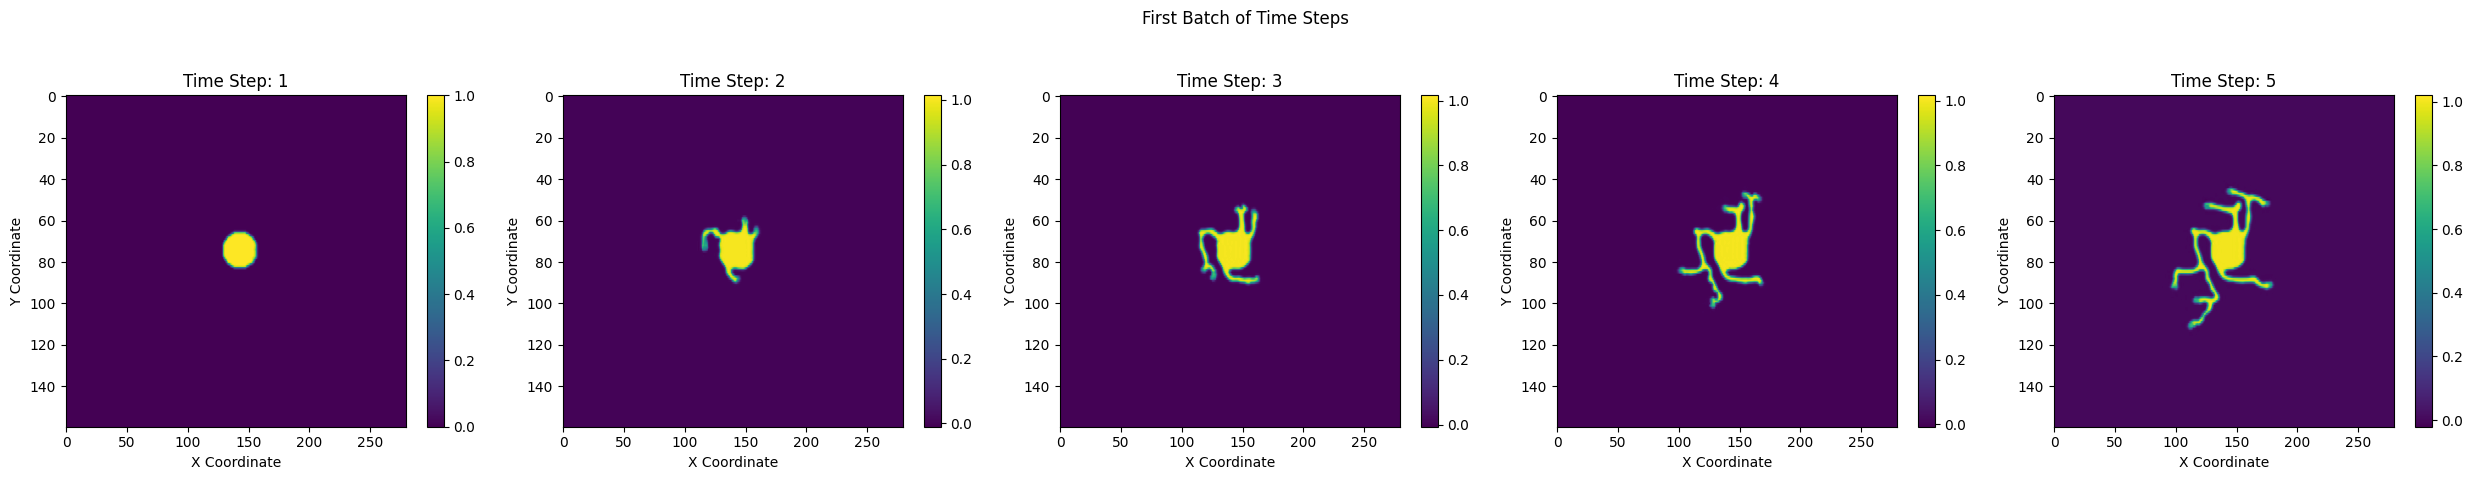

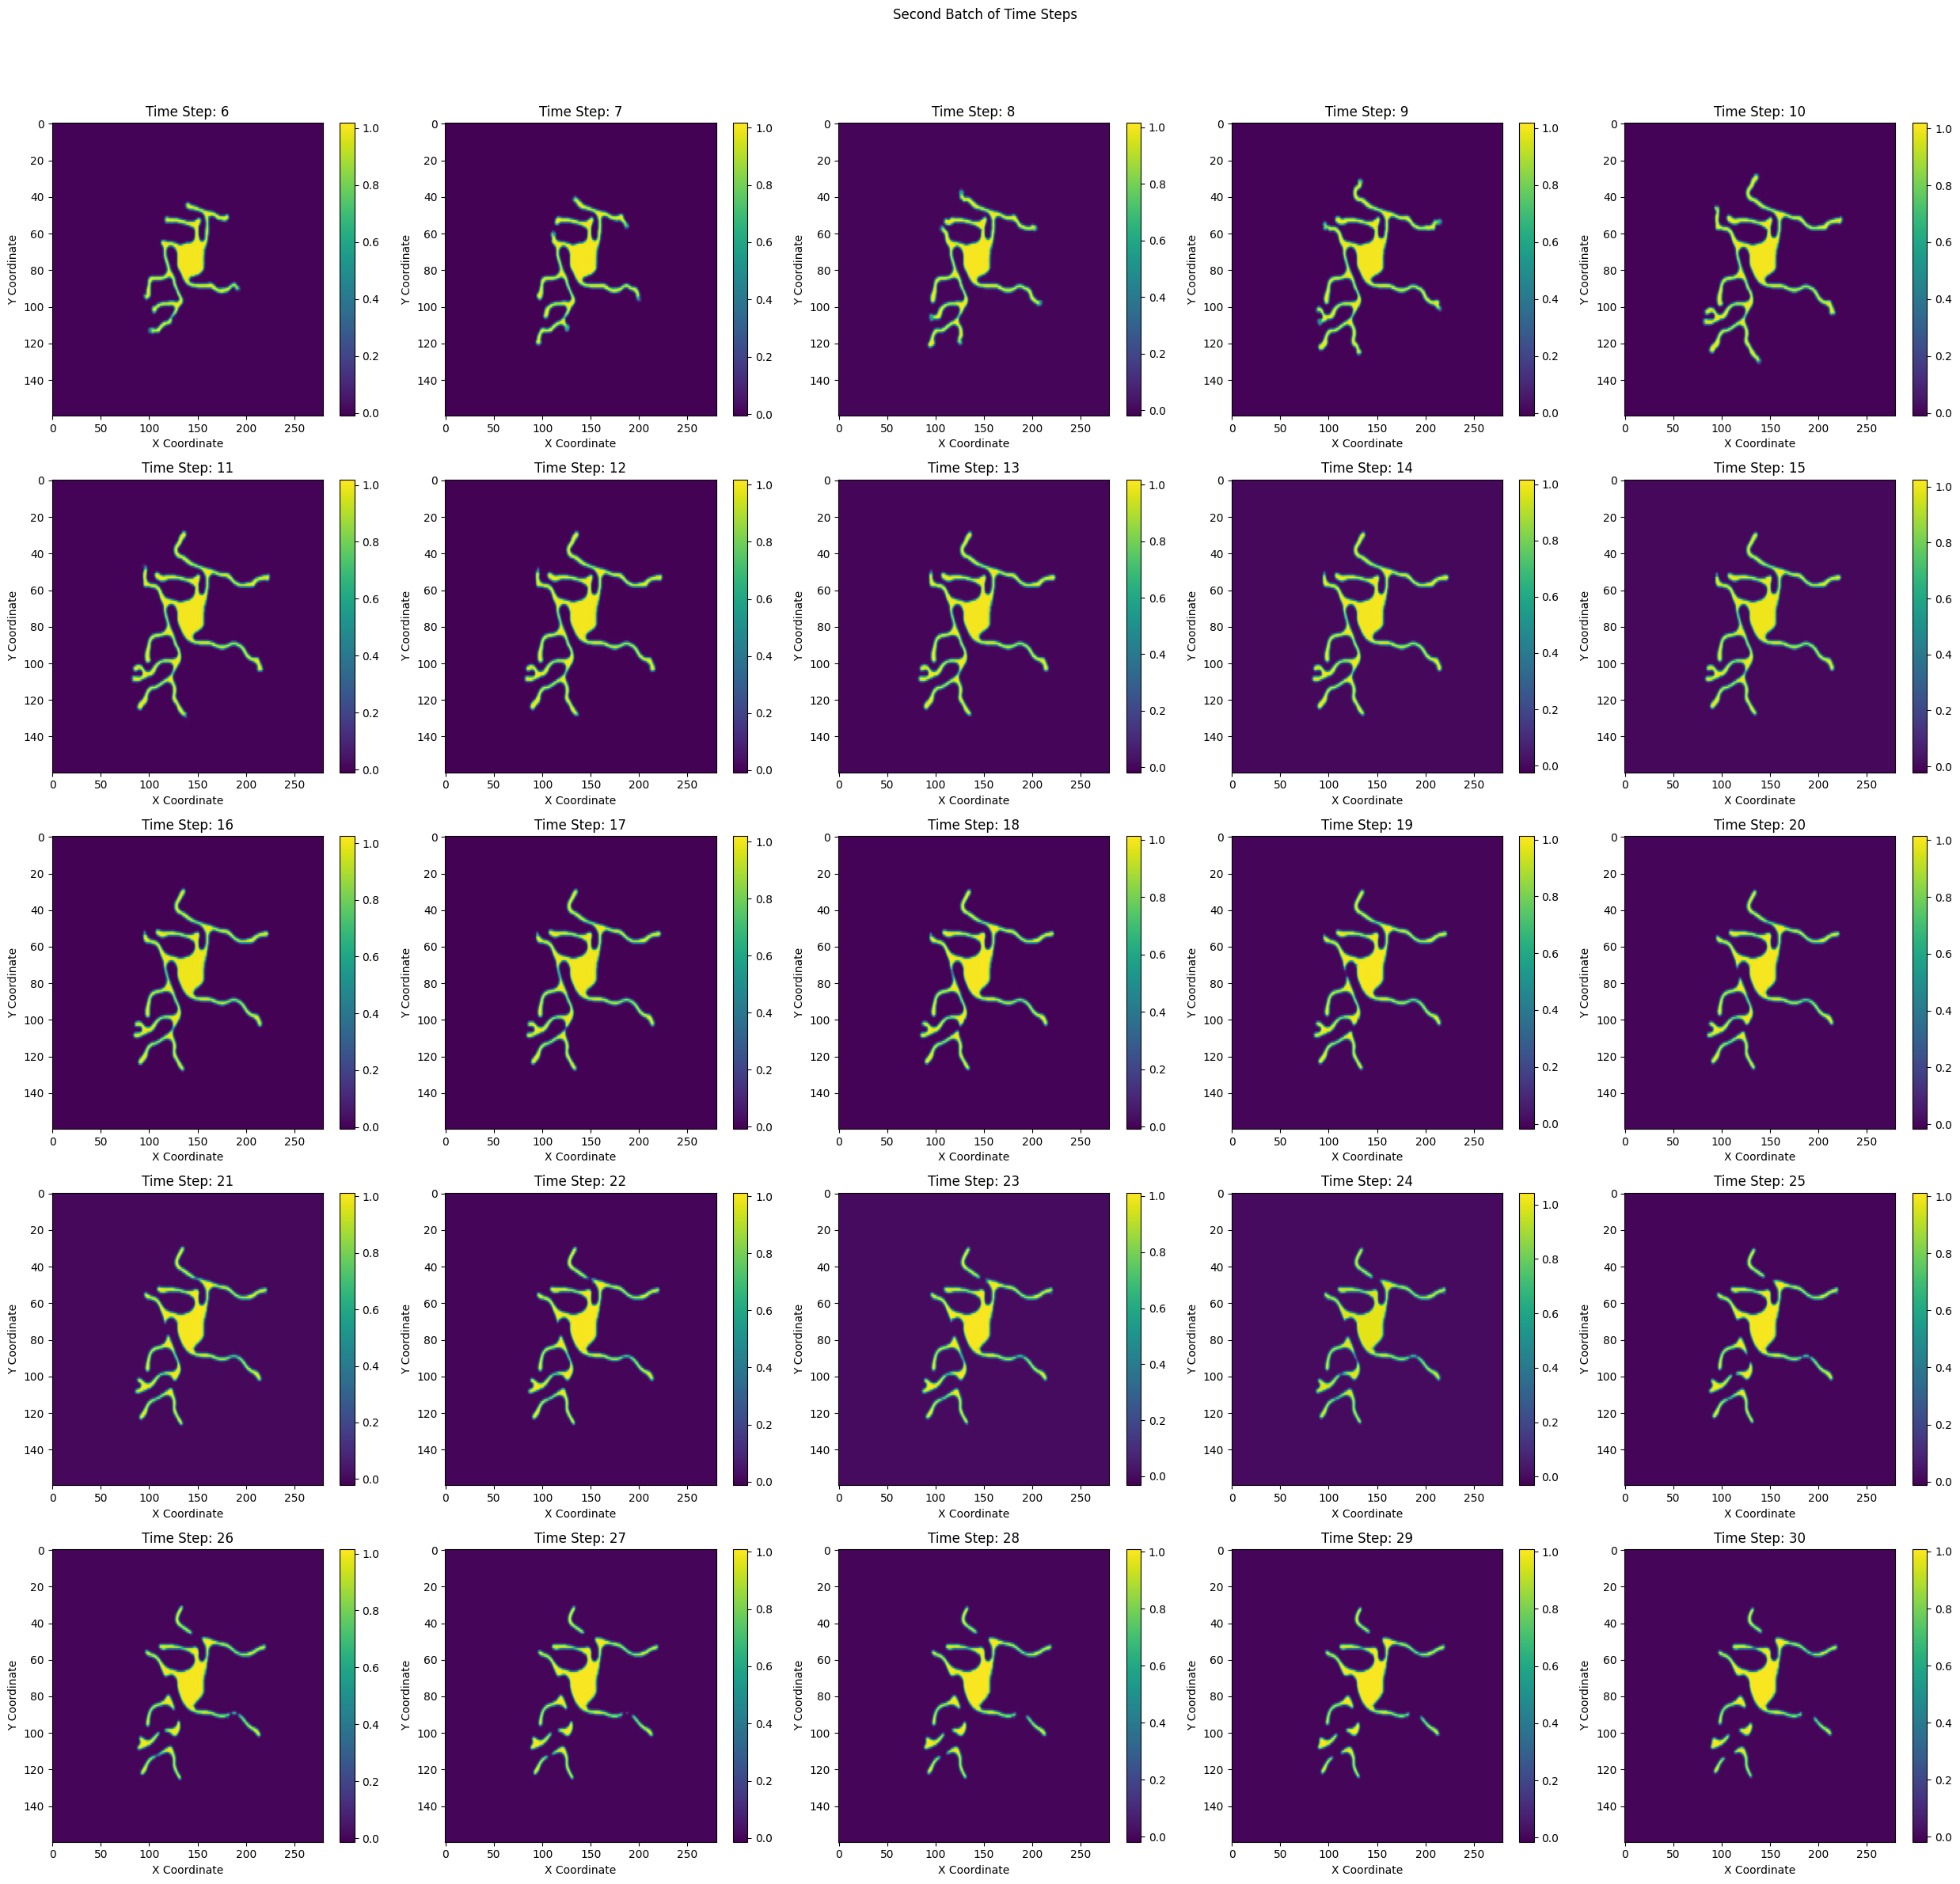

In [14]:
import matplotlib.pyplot as plt
import numpy as np
import random

def plot_interpolated_time_steps(time_step_data, channel, split_at=5, columns_per_row=3):
    """
    Plots the specified channel from each time step's interpolated data, splitting the plots into two figures.

    Args:
        time_step_data (list of dicts): Each dict contains channel names as keys and 2D arrays of data as values.
        channel (str): Name of the channel to plot.
        split_at (int): Index at which to split the plots into a second figure.
        columns_per_row (int): Number of columns per row in the plot.

    Returns:
        None: Displays the plots.
    """
    
    num_time_steps = len(time_step_data)
    first_batch = min(num_time_steps, split_at)
    second_batch = num_time_steps - first_batch

    # Function to create plots for a given range of time steps
    def plot_batch(start_index, end_index, title):
        num_plots = end_index - start_index
        rows = (num_plots + columns_per_row - 1) // columns_per_row  # Calculate rows needed
        fig, axes = plt.subplots(rows, columns_per_row, figsize=(5 * columns_per_row, 5 * rows))
        if not isinstance(axes, np.ndarray):
            axes = np.array([axes])  # Handle the case where there is only one subplot
        axes = axes.flatten()

        for i in range(num_plots):
            ax = axes[i]
            data_index = start_index + i
            if channel in time_step_data[data_index]:
                c = ax.imshow(time_step_data[data_index][channel], cmap='viridis', aspect='auto')
                fig.colorbar(c, ax=ax)
                ax.set_title(f'Time Step: {data_index + 1}')
                ax.set_xlabel('X Coordinate')
                ax.set_ylabel('Y Coordinate')
            else:
                ax.set_title(f'Channel {channel} not found')
                ax.set_xlabel('X Coordinate')
                ax.set_ylabel('Y Coordinate')
                print(f"Warning: Channel '{channel}' not found in time step {data_index + 1}.")

        for j in range(i + 1, len(axes)):  # Hide unused axes
            axes[j].axis('off')

        plt.suptitle(title)
        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        plt.show()

    # Plot the first batch of time steps
    plot_batch(0, first_batch, "First Batch of Time Steps")

    # Plot the second batch of time steps if there are any
    if second_batch > 0:
        plot_batch(first_batch, num_time_steps, "Second Batch of Time Steps")

# Randomly select a case key from all_cases_data
case_key = random.choice(list(all_cases_data.keys()))  # Randomly pick a case key
channel_to_plot = 'phi'  # Example channel to plot

# Now use the variable to access data and call the plotting function
plot_interpolated_time_steps(all_cases_data[case_key][0], channel_to_plot, columns_per_row=5)


In [12]:
import numpy as np
import random

def select_and_structure_data(all_cases_data, num_X_steps=10, num_Y_steps=20, train_frac=0.7, val_frac=0.15, channels=None):
    """
    Structured data extraction for ML training from multidimensional time-series data.

    Args:
        all_cases_data (dict): The main dataset containing all cases.
        num_X_steps (int): Number of time steps to use for X.
        num_Y_steps (int): Number of time steps to use for Y.
        train_frac (float): Fraction of data to be used for training.
        val_frac (float): Fraction of data to be used for validation.
        channels (list): List of channel names to include in the output arrays.

    Returns:
        dict: Dataset containing structured data for training, validation, and testing.
    """

    # Extract keys for all cases
    case_keys = list(all_cases_data.keys())
    random.shuffle(case_keys)

    # Determine split indices
    num_train = int(len(case_keys) * train_frac)
    num_val = int(len(case_keys) * val_frac)
    
    train_keys = case_keys[:num_train]
    val_keys = case_keys[num_train:num_train + num_val]
    test_keys = case_keys[num_train + num_val:]

    # Define function to extract data for X and Y
    def extract_data(cases, num_X_steps, num_Y_steps, channels):
        X, Y = [], []
        for case in cases:
            case_data = all_cases_data[case][0]  # Assuming the data structure is (list of dicts with channel data, grid_x, grid_y)
            # print(case_data)
            print(case)
            case_data[0]['phi']
            if len(case_data) >= num_X_steps + num_Y_steps:
                x_segments = np.stack([np.array([time_step[channel] for time_step in case_data[:num_X_steps]]) for channel in channels if channel in case_data[0]], axis=1)
                y_segments = np.stack([np.array([time_step[channel] for time_step in case_data[num_X_steps:num_X_steps + num_Y_steps]]) for channel in channels if channel in case_data[0]], axis=1)

                X.append(x_segments)
                Y.append(y_segments)

        return np.array(X), np.array(Y)

    # Extract data for each dataset
    X_train, Y_train = extract_data(train_keys, num_X_steps, num_Y_steps, channels)
    X_val, Y_val = extract_data(val_keys, num_X_steps, num_Y_steps, channels)
    X_test, Y_test = extract_data(test_keys, num_X_steps, num_Y_steps, channels)

    return {
        'X_train': X_train, 'Y_train': Y_train,
        'X_val': X_val, 'Y_val': Y_val,
        'X_test': X_test, 'Y_test': Y_test
    }

# Example usage: specify which channels to include
# channels_to_include = ['phi', 'synaptogenesis', 'tubulin', 'tips', 'theta']  # Add your specific channels here
channels_to_include = ['phi']  # Add your specific channels here
dataset = select_and_structure_data(all_cases_data, channels=channels_to_include)

# Display the shapes of the datasets
for key in dataset:
    print(f"{key} shape: {dataset[key].shape if dataset[key].size else 'Empty'}")

io2D_ND03
io2D_ND29
io2D_ND36
io2D_ND37
io2D_ND38
io2D_ND56
io2D_ND57
io2D_ND44
io2D_ND11
io2D_ND27
io2D_ND46
io2D_ND54
io2D_ND49
io2D_ND02
io2D_ND15
io2D_ND28
io2D_ND09
io2D_ND06
io2D_ND10
io2D_ND35
io2D_ND08
io2D_ND42
io2D_ND14
io2D_ND59
io2D_ND60
io2D_ND45
io2D_ND55
io2D_ND53
io2D_ND48
io2D_ND18
io2D_ND47
io2D_ND01
io2D_ND25
io2D_ND04
io2D_ND20
io2D_ND32
io2D_ND05
io2D_ND40
io2D_ND23
io2D_ND39
io2D_ND34
io2D_ND21
io2D_ND43
io2D_ND19
io2D_ND30
io2D_ND17
io2D_ND07
io2D_ND12
io2D_ND24
io2D_ND16
io2D_ND31
X_train shape: (35, 10, 1, 160, 280)
Y_train shape: (35, 20, 1, 160, 280)
X_val shape: (7, 10, 1, 160, 280)
Y_val shape: (7, 20, 1, 160, 280)
X_test shape: (9, 10, 1, 160, 280)
Y_test shape: (9, 20, 1, 160, 280)


In [13]:
import pickle

# Save the dataset to a .pkl file using pickle
with open('./reformatedNDDs/dataset.pkl', 'wb') as f:
    pickle.dump(dataset, f)